Tommaso Peritore

# Exercise 11

## Overview 


In this notebook our task will be to perform machine learning regression on noisy data with a Neural Network (NN).

We will explore how the ability to fit depends on the structure of the NN. The goal is also to build intuition about why prediction is difficult.

### The Prediction Problem


Consider a probabilistic process that gives rise to labeled data $(x,y)$. The data is generated by drawing samples from the equation

$$
    y_i= f(x_i) + \eta_i,
$$

where $f(x_i)$ is some fixed, but (possibly unknown) function, and $\eta_i$ is a Gaussian, uncorrelate noise variable such that

$$
\langle \eta_i \rangle=0 \\
\langle \eta_i \eta_j \rangle = \delta_{ij} \sigma
$$

We will refer to the $f(x_i)$ as the **true features** used to generate the data. 

To make predictions, we will consider a NN that depends on its parameters, weights and biases. The functions that the NN can model respresent the **model class** that we are using to try to model the data and make predictions.

To learn the parameters of the NN, we will train our models on a **training data set** and then test the effectiveness of the NN on a *different* dataset, the **validation data set**. The reason we must divide our data into a training and test dataset is that the point of machine learning is to make accurate predictions about new data we have not seen.

To measure our ability to predict, we will learn our parameters by fitting our training dataset and then making predictions on our test data set. One common measure of predictive  performance of our algorithm is to compare the predictions,$\{y_j^\mathrm{pred}\}$, to the true values $\{y_j\}$. A commonly employed measure for this is the sum of the mean square-error (MSE) on the test set:
$$
MSE= \frac{1}{N_\mathrm{test}}\sum_{j=1}^{N_\mathrm{test}} (y_j^\mathrm{pred}-y_j)^2
$$

We will try to get a qualitative picture by examining plots on validation and training data.

### Linear fit


We start by considering the very simple case:
$$
f(x)=2x+1
$$

Let's start defining the parameters of an ideal linear function which we are going to predict through a neural network regression

In [1]:
# target parameters of f(x) = m*x + b
m = 2 # slope
b = 1 # intersect

Now let's generate a set of input data which will slightly deviate from our ideal behaviour using a random noise (that actually is set to zero):

In [2]:
import numpy as np

# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 500)
x_valid = np.random.uniform(-1, 1, 50)
x_valid.sort()
y_target = m * x_valid + b # ideal (target) linear function

sigma = 1 # noise standard deviation, for the moment it is absent
y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)

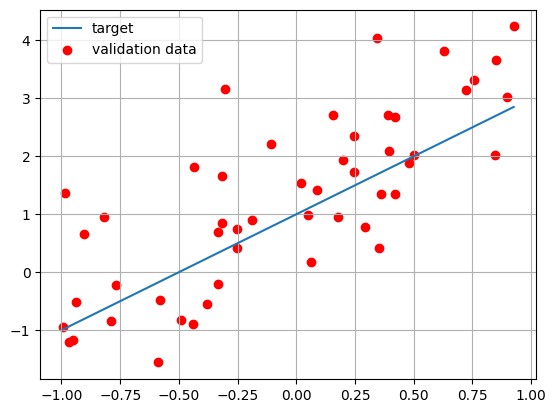

In [3]:
# plot validation and target dataset
import matplotlib.pyplot as plt
plt.plot(x_valid, y_target, label='target')
plt.scatter(x_valid, y_valid, color='r', label='validation data')
plt.legend()
plt.grid(True)
plt.show()

If you remember how a single node of a neural network works, you can easily spot that **just a single neuron can make the job**. So let's start using a simple Sequential model with just one layer on one neuron only!

In [4]:
# compose the NN model
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
#from tensorflow.keras import backend as K
#from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,)))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

In [5]:
# get a summary of our composed model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We are now going to train our model, that is we feed the neuron with the set of training pair x, y_train from which the optimizer will find the best weights to minimize the Mean Square Error loss function (out linear regression function).

In [6]:
# fit the model using training dataset
# over 10 epochs of 32 batch size each
# report training progress against validation data
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=30,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

Epoch 1/30
16/16 [==============================] - 0s 10ms/step - loss: 1.7721 - mse: 1.7721 - val_loss: 2.1966 - val_mse: 2.1966
Epoch 2/30
16/16 [==============================] - 0s 2ms/step - loss: 1.4523 - mse: 1.4523 - val_loss: 1.8206 - val_mse: 1.8206
Epoch 3/30
16/16 [==============================] - 0s 4ms/step - loss: 1.2709 - mse: 1.2709 - val_loss: 1.5868 - val_mse: 1.5868
Epoch 4/30
16/16 [==============================] - 0s 2ms/step - loss: 1.1682 - mse: 1.1682 - val_loss: 1.4351 - val_mse: 1.4351
Epoch 5/30
16/16 [==============================] - 0s 2ms/step - loss: 1.1076 - mse: 1.1076 - val_loss: 1.3356 - val_mse: 1.3356
Epoch 6/30
16/16 [==============================] - 0s 2ms/step - loss: 1.0691 - mse: 1.0691 - val_loss: 1.2627 - val_mse: 1.2627
Epoch 7/30
16/16 [==============================] - 0s 2ms/step - loss: 1.0440 - mse: 1.0440 - val_loss: 1.2158 - val_mse: 1.2158
Epoch 8/30
16/16 [==============================] - 0s 2ms/step - loss: 1.0278 - mse: 1.0

By looking at weights and biases we can see if the linear fit was successfull: $w_1$ represents the angular coefficient, $b$ the intercept.

In [7]:
# return weights and biases
model.get_weights()

[array([[2.0718315]], dtype=float32), array([0.89027923], dtype=float32)]

In [8]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=32, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 0s 3ms/step - loss: 1.1152 - mse: 1.1152

Test loss: 1.1152232885360718
Test accuracy: 1.1152232885360718


In [9]:
# evaluate model with the exact curve
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 0s 4ms/step - loss: 0.0145 - mse: 0.0145

Test loss: 0.014509743079543114
Test accuracy: 0.014509743079543114


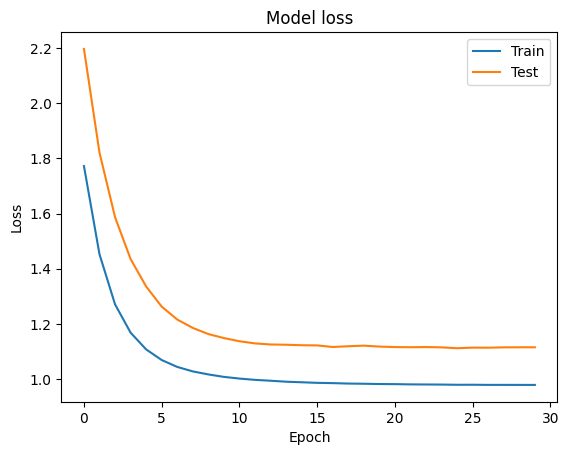

In [10]:
# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

4/4 [==============================] - 0s 1ms/step


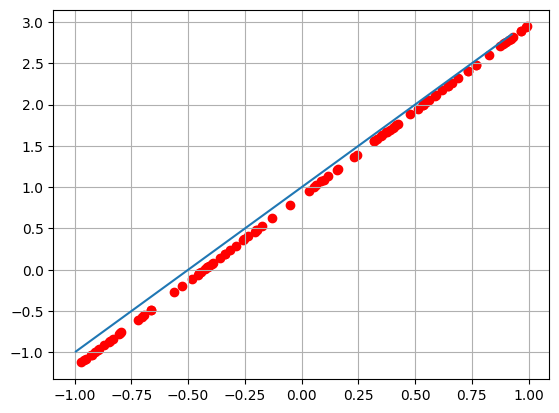

In [11]:
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

## 11.1

In order to make practice with NN, explore how does the previous linear regression depend on the number of epochs, $N_{\mathrm{epochs}}$, the number of data points $N_{\mathrm{train}}$ and on the noise $\sigma$. Try to improve the previous result operating on these parameters.

## Solution

Comment on tests for $N_{epochs}$ etc.